Имеется набор данных из картинок и текстовых файлов, в которых указан класс объекта и координаты bounding box в формате xmin ymin xmax ymax - это абсолютные координаты bouding box’а на изображении, левого верхнего и правого нижнего углов соответственно.

Для удобства работы с данными, сделаю датасет с перечнем имен файлов с картинками и данными о классе и координатах боксов

In [1]:
import numpy as np
import pandas as pd
import os
from os import path

from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset , DataLoader , SubsetRandomSampler

In [2]:
# указал путь к данным
DATA_PATH = 'data/'

# создам пустой датафрейм с нужными столбцами
columns = ['idx', 'img_name', 'target', 'xmin', 'ymin', 'xmax', 'ymax']

cats_dogs_data = pd.DataFrame(columns = columns)

In [3]:
# получу список всех файлов
file_list = sorted(os.listdir(DATA_PATH))

In [4]:
# создам список всех имен файлов для дальнейшего формирования датафрейма
file_name = []
for f_name in file_list:
    if os.path.splitext(f_name)[0] not in file_name:
        file_name.append(os.path.splitext(f_name)[0])

In [5]:
# переносим данные в датафрейм, сразу заменил метку класса с 2 на 0
for i, fname in enumerate(file_name):
    with open(DATA_PATH + fname + '.txt') as f:
        line = f.readline().split()
        
    cats_dogs_data.loc[i] = [i, DATA_PATH + fname + '.jpg', 
                             0 if int(line[0]) == 2 else int(line[0]), 
                             int(line[1]), 
                             int(line[2]), 
                             int(line[3]), 
                             int(line[4])]

-------------------------------------------

In [7]:
cats_dogs_data.to_csv('cats_dogs.csv', index = False)

In [3]:
cats_dogs_data = pd.read_csv('cats_dogs.csv')

-----------------------------------------------------------

In [6]:
# получился такой датасет
cats_dogs_data

,idx,img_name,target,xmin,ymin,xmax,ymax
0,0,data/Abyssinian_1.jpg,1,333,72,425,158
1,1,data/Abyssinian_10.jpg,1,72,105,288,291
2,2,data/Abyssinian_100.jpg,1,151,71,335,267
3,3,data/Abyssinian_101.jpg,1,54,36,319,235
4,4,data/Abyssinian_102.jpg,1,23,27,325,320
...,...,...,...,...,...,...,...
3380,3380,data/yorkshire_terrier_186.jpg,0,208,32,356,231
3381,3381,data/yorkshire_terrier_187.jpg,0,187,49,317,181
3382,3382,data/yorkshire_terrier_188.jpg,0,94,36,378,263
3383,3383,data/yorkshire_terrier_189.jpg,0,274,84,402,207


In [8]:
print('Кошечек в датасете {} шт.'.format(len(cats_dogs_data[cats_dogs_data['target'] == 1])))
print('Собачек в датасете {} шт.'.format(len(cats_dogs_data[cats_dogs_data['target'] == 0])))

Кошечек в датасете 1037 шт.
Собачек в датасете 2348 шт.


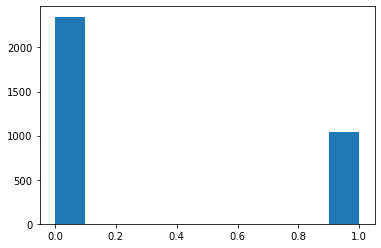

In [9]:
plt.hist(cats_dogs_data['target']);

Датасет несбарансированный, кошек меньше 30% от общего объема данных и более чем в два раза меньше чем собак. Сначала попробую обучать на данных как есть, потом попробую каким-нибудь способом сбалансировать выборку

Следующий этап - это создание даталоадера, который будет подгружать картинки и данные о разметке в процессе работы. Реализовал в отдельном скрипте cd_dataset.py

In [10]:
from cd_dataset import Cats_and_Dogs

In [11]:
train_dataset = Cats_and_Dogs(cats_dogs_data)

Разделю выборку на тренировочную и тестовую применив стратификацию встроенную в готовую функцию train_test_split. Из этого разделения мне нужны только id строк

In [12]:
X = cats_dogs_data.idx
y = cats_dogs_data.target

train_idx, val_idx, _, _ = train_test_split(X, y, test_size = 0.3, stratify = y)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size = 4, sampler = train_idx, collate_fn = collate_fn)
valid_loader =  DataLoader(train_dataset, batch_size = 4, sampler = val_idx, collate_fn = collate_fn)

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
#Можно посмотреть как разбились классы в тренировочном и валидационном датасетах
print('Количество собак в тренировочном датасете - {}'.format(
      len(cats_dogs_data.loc[train_idx][cats_dogs_data.target == 2])))
print('Количество кошек в тренировочном датасете - {}'.format(
      len(cats_dogs_data.loc[train_idx][cats_dogs_data.target == 1])))
print()
print('Количество собак в валидационном датасете - {}'.format(
      len(cats_dogs_data.loc[val_idx][cats_dogs_data.target == 2])))
print('Количество кошек в валидационном датасете - {}'.format(
      len(cats_dogs_data.loc[val_idx][cats_dogs_data.target == 1])))

Количество собак в тренировочном датасете - 0
Количество кошек в тренировочном датасете - 726

Количество собак в валидационном датасете - 0
Количество кошек в валидационном датасете - 311


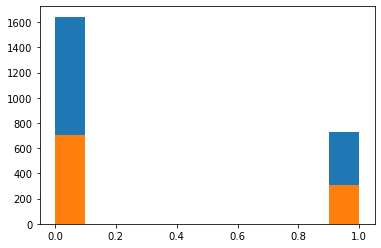

In [15]:
plt.hist(cats_dogs_data.loc[train_idx]['target']);
plt.hist(cats_dogs_data.loc[val_idx]['target']);

Как видно, баланс классов сохранился, буду надеятся это поможет лучше обучить модель

In [16]:
# дополнительная функция для преобразования картинки с боксом в массив нампай
# и вывод случайной картинки чтобы посмотреть на данные
from utils import plot_img, show_random_pict

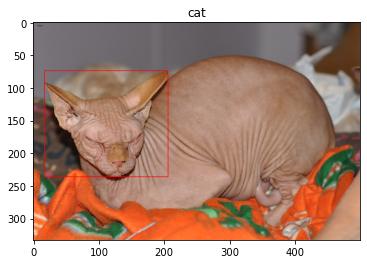

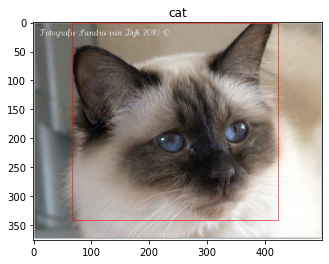

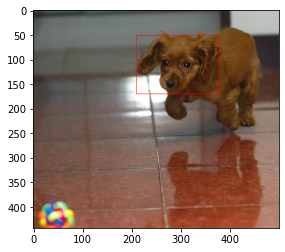

In [17]:
for i in range(3):
    show_random_pict(cats_dogs_data)

### Модель

За основную модель взята предобученная FasterRCNN_Resnet50, которую я модифицирую и дообучу на предоставленном датасете

In [12]:
# загрузка модели выполнена в отдельном скрипте
from model import My_Cnn

In [106]:
my_model = My_Cnn()

In [107]:
optimizer = torch.optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
criterion_class = nn.BCEWithLogitsLoss()
criterion_bbox = nn.MSELoss()

In [126]:
def train(train_dataloader):
    my_model.train()
    running_loss = 0
    for images, targets in train_dataloader:
        print(targets)
        images = torch.stack(images)
        targets = torch.stack(targets)
        labels = targets[:,-1:]
        bboxes = tuple((targets[:,0:1], targets[:,1:2], targets[:,2:3], targets[:,3:4]))
        #print(targets)
        #print(bboxes)
        #break
        optimizer.zero_grad()
        #images, targets = data[0], data[1] #, data[2]
        #images = list(image.to(device) for image in images)
        #images = list(image.to('cpu') for image in data[0])
        #print(data[0].shape)
        #print(images.shape)
        #images = data[0]
        #images = list(image for image in images)
        #break
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = my_model(images)
        print('outputs : ', outputs)
        
        #preds = torch.stack(outputs)
        #print('preds : ', preds)
        print('labels : ', outputs[-1:][0])
        #return outputs
        #break
        loss_cl = criterion_class(outputs[-1:][0], labels)
        loss_bbox = []
        for i in range(4):
            loss_bbox.append(criterion_bbox(outputs[:-1][i], bboxes[i]))
        #loss = criterion(preds, labels) #, targets)
        full_loss = sum(loss for loss in loss_bbox)*0.5 + loss_cl*0.5
        print('class : ', loss_cl)
        print('bbox : ', loss_bbox)
        print('full_loss : ', full_loss)
        #break
        #loss = sum(loss for loss in loss_dict.values())
        #running_loss += loss #.item()
        full_loss.backward()
        print('backward')
        optimizer.step()
        print('step')
        if i % 50 == 0:
            print(f"Iteration #{i} train_loss: {loss}")
        break
    train_loss = running_loss/len(train_dataloader.dataset)         

    return train_loss

In [ ]:
train(train_loader)

(tensor([0.2167, 0.1333, 0.7033, 0.5956, 0.0000]), tensor([0.2680, 0.1947, 0.8260, 0.8640, 0.0000]), tensor([0.0721, 0.0460, 0.6306, 0.4440, 0.0000]), tensor([0.1231, 0.6680, 0.6216, 0.9640, 0.0000]))
x in:  torch.Size([4, 3, 250, 250])
x from 1 layer :  torch.Size([4, 64, 250, 250])
x from 2 layer :  torch.Size([4, 128, 63, 63])
x from 3 layer :  torch.Size([4, 256, 16, 16])
x from 4 layer :  torch.Size([4, 512, 4, 4])
x after view :  torch.Size([4, 8192])
outputs :  (tensor([[ 0.2504],
        [ 0.1753],
        [ 0.2031],
        [-0.1200]], grad_fn=<AddmmBackward>), tensor([[-0.2657],
        [-0.3193],
        [-0.3302],
        [-0.1258]], grad_fn=<AddmmBackward>), tensor([[ 0.0869],
        [-0.0456],
        [-0.0347],
        [-0.2021]], grad_fn=<AddmmBackward>), tensor([[ 0.6953],
        [ 0.0028],
        [ 0.0217],
        [-0.2104]], grad_fn=<AddmmBackward>), tensor([[ 0.3840],
        [ 0.0863],
        [-0.0779],
        [ 0.3441]], grad_fn=<AddmmBackward>))
labels :  t